# Model Zoo (Dense)

In [1]:
%env CUDA_VISIBLE_DEVICES=1

import numpy as np
import torch

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from torch.utils.data import Subset

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import torchvision.models as models
from torchvision.models import vgg19, resnet50, resnet18, resnet34, resnet101 
import timm # state-of-the-art (ViTs...)
from huggingface_hub import hf_hub_download

# from src.model_serving.model_server import *
import matplotlib.pyplot as plt

from datetime import datetime
import time

import csv

env: CUDA_VISIBLE_DEVICES=1


In [2]:
# https://github.com/chenyaofo/pytorch-cifar-models
MODELS_V1 = [
    'mobilenetv2_x0_5',
    'mobilenetv2_x0_75',
    'mobilenetv2_x1_0',
    'mobilenetv2_x1_4',
    'repvgg_a0',
    'repvgg_a1',
    'repvgg_a2',
    'resnet20',
    'resnet32',
    'resnet44',
    'resnet56',
    'shufflenetv2_x0_5',
    'shufflenetv2_x1_0',
    'shufflenetv2_x1_5',
    'shufflenetv2_x2_0',
    'vgg11_bn',
    'vgg13_bn',
    'vgg16_bn',
    'vgg19_bn',
 ]
VISION_TRANSFORMERS = [
    'vit_small_patch16_384',
    'vit_base_patch16_384',
    'vit_large_patch16_384',
]
CONVNEXTS = [
    'convnext_tiny',
    'convnext_base',
    'convnext_large',
]

V1_MODELS_UPSTREAM = "chenyaofo/pytorch-cifar-models"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(f"available_gpus: {len(available_gpus)}") 

Using cuda device
available_gpus: 1


In [4]:
'''
from src.model_serving.model_server import *
import matplotlib.pyplot as plt

def profile_pt_model_(model_zoo, model_id: str, test_data: Dataset, latency_sample=1000):
    """
    Profile a pytorch model using all data in test_data and measure latency by 
    performing at most `latency_sample` number of queries.
    """
    print(f"Start profiling {model_id} ...")

    size = len(test_data)
    correct = 0
    with torch.no_grad():
        for X, y in DataLoader(test_data, batch_size=256):
            X, y = X.to(device), y.to(device)
            pred = model_zoo[model_id](X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    latencies = []
    for X, y in DataLoader(test_data, batch_size=1):
        X, y = X.to(device), y.to(device)
        start = time.perf_counter()
        pred = model_zoo[model_id](X)
        latencies.append((time.perf_counter() - start) * 1000) # convert to ms
        if len(latencies) >= latency_sample:
            break

    plt.cla()
    plt.hist(latencies, 20)
    plt.title(f"Latencies PDF for {model_id}")
    plt.xlabel("Latency (ms)")
    plt.savefig(f"figures/Latencies_PDF_for_{model_id}.png")

    plt.cla()
    plt.hist(latencies, histtype='step', cumulative=True)
    plt.title(f"Latencies CDF for {model_id}")
    plt.xlabel("Latency (ms)")
    plt.savefig(f"figures/Latencies_CDF_for_{model_id}.png")

    accuracy = correct / size
    latency = np.mean(latencies)
    return accuracy, latency
'''

'\nfrom src.model_serving.model_server import *\nimport matplotlib.pyplot as plt\n\ndef profile_pt_model_(model_zoo, model_id: str, test_data: Dataset, latency_sample=1000):\n    """\n    Profile a pytorch model using all data in test_data and measure latency by \n    performing at most `latency_sample` number of queries.\n    """\n    print(f"Start profiling {model_id} ...")\n\n    size = len(test_data)\n    correct = 0\n    with torch.no_grad():\n        for X, y in DataLoader(test_data, batch_size=256):\n            X, y = X.to(device), y.to(device)\n            pred = model_zoo[model_id](X)\n            correct += (pred.argmax(1) == y).type(torch.float).sum().item()\n    \n    latencies = []\n    for X, y in DataLoader(test_data, batch_size=1):\n        X, y = X.to(device), y.to(device)\n        start = time.perf_counter()\n        pred = model_zoo[model_id](X)\n        latencies.append((time.perf_counter() - start) * 1000) # convert to ms\n        if len(latencies) >= latency_samp

In [10]:
# !pip install huggingface_hub -U

In [15]:
model_zoo = {}

def load_model(model_name: str, dataset: str):

    print("load model...")
    
    if dataset == "cifar10":
        n_classes = 10 
    elif dataset == "cifar100":
        n_classes = 100
    else: 
        raise ValueError(f"Unsupported dataset: {args.dataset}")

    print("model_name: {} w/ dataset: {} (n_classes: {})".format(model_name, dataset, n_classes))
    
    if model_name in MODELS_V1:
        model_id = f'{dataset}_{model_name}'
        model = torch.hub.load(V1_MODELS_UPSTREAM, model_id, pretrained=True)
    elif model_name in VISION_TRANSFORMERS or model_name in CONVNEXTS:
        MODEL_REPO = f'tjang31/{model_name}-{dataset}'
        checkpoint_path = hf_hub_download(repo_id=MODEL_REPO, filename="pytorch_model.bin")
        state_dict = torch.load(checkpoint_path, map_location='cpu')

        model = timm.create_model(model_name, pretrained=False)
        if model_name.startswith("vit"):
            model.head = nn.Linear(model.head.in_features, n_classes)
        elif model_name.startswith("convnext"):
            model.head.fc = nn.Linear(model.head.fc.in_features, n_classes)
        else: 
            raise ValueError(f"Unsupported network: {model_name}")
        model.load_state_dict(state_dict)
    else:
        raise ValueError(f"Model {model_id} not available.")
    
    model.eval()
    return model

# TODO 
# model_names = MODELS_V1 + VISION_TRANSFORMERS + CONVNEXTS
model_names = CONVNEXTS

In [6]:
### e.g. 
# model = load_model('vit_base_patch16_384', dataset)

In [7]:
model_names

['convnext_tiny', 'convnext_base', 'convnext_large']

In [25]:
# model_zoo['vit_base_patch16_384']

In [9]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

def get_preprocessor(model_name:str, dataset: str):

    # print("get_preprocessor for {} - {}".format(model_name, dataset))
    
    if dataset == "cifar10":
        _mean = cifar10_mean
        _std = cifar10_std
    elif dataset == "cifar100":
        _mean = cifar100_mean
        _std = cifar100_std
    else: 
        raise ValueError(f"Unsupported dataset: {dataset}")

    if model_name in MODELS_V1:
        preprocessor = transforms.Compose([
          transforms.Resize(32),
          transforms.CenterCrop(32),
          transforms.ToTensor(),
          transforms.Lambda(lambda t: t[:3, ...]),  # remove the alpha channel
          transforms.Normalize(_mean, _std),
          ])
    elif model_name in VISION_TRANSFORMERS or model_name in CONVNEXTS:
        preprocessor = transforms.Compose([
          transforms.Resize((384, 384)),
          transforms.ToTensor(),
          transforms.Normalize(_mean, _std),
          ])
    else:
        raise ValueError(f"Model {model_name} not available.")
    
    return preprocessor

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
def get_eval_loader(dataset='cifar10', root='./data', transform=None, eval_size=5000, batch_size=8, shuffle=False):

    print("get_eval_loader - {}".format(dataset))
    
    if dataset == 'cifar10':
        _dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    elif dataset == 'cifar100':
        _dataset = datasets.CIFAR100(root=root, train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset. Choose 'cifar10' or 'cifar100'.")

    # Random subset for evaluation
    
    indices = np.random.choice(len(_dataset), eval_size, replace=False)
    eval_data = Subset(_dataset, indices)

    # DataLoader for evaluation
    eval_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    
    return eval_loader

In [12]:
def evaluate_model(model, data_loader, device):
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    total_time = 0

    data_processed = 0 
    last_logged = 0
    
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in data_loader:
            
            images, labels = images.to(device), labels.to(device)
            
            start_time = time.time()
            outputs = model(images)
            latency = time.time() - start_time
            total_time += latency
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            data_processed += labels.size(0)
            
            if data_processed - last_logged >= 500:
                print(f"Processed {data_processed}/{len(data_loader.dataset)} images...")
                last_logged = data_processed

    accuracy = 100 * correct / total
    avg_latency = total_time / len(data_loader)
    
    return accuracy, avg_latency

In [13]:
def profile_pt_models(dataset):

    model_zoo_ = {}
    for model_name in model_names:
        print("loading... ", model_name)
        model = load_model(model_name, dataset)
        model_zoo_[model_name] = model

    results = {}

    for model_name, model in model_zoo_.items():
    
        transform = get_preprocessor(model_name, dataset)
        eval_loader = get_eval_loader(dataset=dataset, root='./data', transform=transform, eval_size=5000, batch_size=8, shuffle=False)
    
        print(f"Evaluating {model_name}...")
        accuracy, latency = evaluate_model(model, eval_loader, device)
        results[model_name] = {'accuracy': accuracy, 'latency': latency}
        print(f"{model_name}: Accuracy = {accuracy:.2f}%, Latency = {latency:.6f} seconds")
    
    for model_name, metrics in results.items():
        print(f"Model: {model_name}, Accuracy: {metrics['accuracy']:.2f}%, Latency: {metrics['latency']:.6f} seconds")

    return results

# model zoo for CIFAR-10

In [17]:
cifar10_results = profile_pt_models(dataset = "cifar10")

loading...  convnext_tiny
load model...
model_name: convnext_tiny w/ dataset: cifar10 (n_classes: 10)


/tmp/ipykernel_2221222/2728602005.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location='cpu')


loading...  convnext_base
load model...
model_name: convnext_base w/ dataset: cifar10 (n_classes: 10)
loading...  convnext_large
load model...
model_name: convnext_large w/ dataset: cifar10 (n_classes: 10)


pytorch_model.bin:  35%|###4      | 273M/785M [00:00<?, ?B/s]

get_eval_loader - cifar10
Files already downloaded and verified
Evaluating convnext_tiny...
Processed 504/5000 images...
Processed 1008/5000 images...
Processed 1512/5000 images...
Processed 2016/5000 images...
Processed 2520/5000 images...
Processed 3024/5000 images...
Processed 3528/5000 images...
Processed 4032/5000 images...
Processed 4536/5000 images...
convnext_tiny: Accuracy = 98.06%, Latency = 0.004081 seconds
get_eval_loader - cifar10
Files already downloaded and verified
Evaluating convnext_base...
Processed 504/5000 images...
Processed 1008/5000 images...
Processed 1512/5000 images...
Processed 2016/5000 images...
Processed 2520/5000 images...
Processed 3024/5000 images...
Processed 3528/5000 images...
Processed 4032/5000 images...
Processed 4536/5000 images...
convnext_base: Accuracy = 98.62%, Latency = 0.007179 seconds
get_eval_loader - cifar10
Files already downloaded and verified
Evaluating convnext_large...
Processed 504/5000 images...
Processed 1008/5000 images...
Proc

In [89]:
# cifar10_results = profile_pt_models(dataset = "cifar10")


# Convert CSV back to JSON
csv_file = "dataset/cifar10.csv"

# Read the CSV file and convert to JSON
cifar10_results = {}
with open(csv_file, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        model = row["Model"]
        accuracy = float(row["Accuracy"])
        latency = float(row["Latency"])

        cifar10_results[model] = {"accuracy": accuracy, "latency": latency}

In [92]:
cifar10_results

{'mobilenetv2_x0_5': {'accuracy': 93.14, 'latency': 37.05},
 'mobilenetv2_x0_75': {'accuracy': 94.08, 'latency': 37.24},
 'mobilenetv2_x1_0': {'accuracy': 93.94, 'latency': 36.74},
 'mobilenetv2_x1_4': {'accuracy': 94.24, 'latency': 37.28},
 'repvgg_a0': {'accuracy': 94.32, 'latency': 41.06},
 'repvgg_a1': {'accuracy': 95.5, 'latency': 42.77},
 'repvgg_a2': {'accuracy': 95.22, 'latency': 43.98},
 'resnet20': {'accuracy': 92.68, 'latency': 17.45},
 'resnet32': {'accuracy': 93.7, 'latency': 26.64},
 'resnet44': {'accuracy': 93.92, 'latency': 33.15},
 'resnet56': {'accuracy': 94.26, 'latency': 44.26},
 'shufflenetv2_x0_5': {'accuracy': 90.6, 'latency': 44.63},
 'shufflenetv2_x1_0': {'accuracy': 93.74, 'latency': 46.28},
 'shufflenetv2_x1_5': {'accuracy': 93.7, 'latency': 45.31},
 'shufflenetv2_x2_0': {'accuracy': 93.68, 'latency': 47.42},
 'vgg11_bn': {'accuracy': 93.22, 'latency': 11.07},
 'vgg13_bn': {'accuracy': 93.72, 'latency': 12.83},
 'vgg16_bn': {'accuracy': 93.92, 'latency': 15.1

In [90]:
latencies = [metrics['latency'] for model_name, metrics in cifar10_results.items()]
accuracies = [metrics['accuracy'] for model_name, metrics in cifar10_results.items()]

mobilenetv2_x0_5, acc: 93.14, mean latency: 37.050 ms
mobilenetv2_x0_75, acc: 94.08, mean latency: 37.240 ms
mobilenetv2_x1_0, acc: 93.94, mean latency: 36.740 ms
mobilenetv2_x1_4, acc: 94.24, mean latency: 37.280 ms
repvgg_a0, acc: 94.32, mean latency: 41.060 ms
repvgg_a1, acc: 95.5, mean latency: 42.770 ms
repvgg_a2, acc: 95.22, mean latency: 43.980 ms
resnet20, acc: 92.68, mean latency: 17.450 ms
resnet32, acc: 93.7, mean latency: 26.640 ms
resnet44, acc: 93.92, mean latency: 33.150 ms
resnet56, acc: 94.26, mean latency: 44.260 ms
shufflenetv2_x0_5, acc: 90.6, mean latency: 44.630 ms
shufflenetv2_x1_0, acc: 93.74, mean latency: 46.280 ms
shufflenetv2_x1_5, acc: 93.7, mean latency: 45.310 ms
shufflenetv2_x2_0, acc: 93.68, mean latency: 47.420 ms
vgg11_bn, acc: 93.22, mean latency: 11.070 ms
vgg13_bn, acc: 93.72, mean latency: 12.830 ms
vgg16_bn, acc: 93.92, mean latency: 15.140 ms
vgg19_bn, acc: 94.3, mean latency: 18.170 ms
vit_small_patch16_384, acc: 98.02, mean latency: 35.860 ms


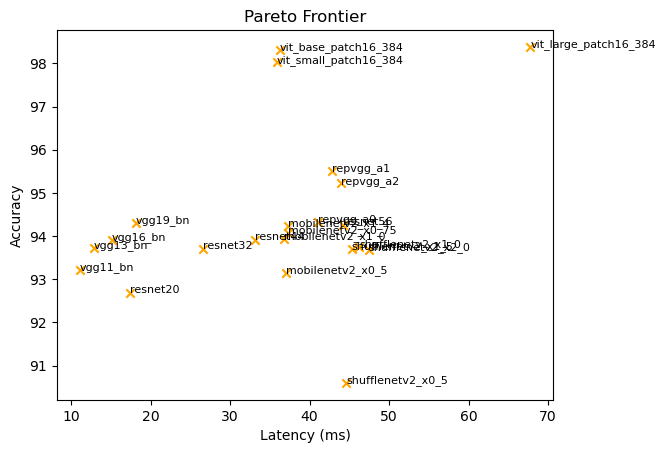

In [91]:
for model_name, metrics in cifar10_results.items():
    print(f"{model_name}, acc: {metrics['accuracy']}, mean latency: {metrics['latency']:.3f} ms")
    
plt.scatter(latencies, accuracies, label="Models", color='orange', marker='x')

for model_name, metrics in cifar10_results.items():
    plt.text(metrics['latency'], metrics['accuracy'], model_name, fontsize=8)

plt.title("Pareto Frontier")
plt.xlabel("Latency (ms)")
plt.ylabel("Accuracy")

current = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f"figures/Pareto_Frontier_{current}.png")

In [41]:
def get_n_params(model):
    return sum(p.numel() for p in model.parameters())

get_n_params(model_zoo['resnet18'])

11689512

In [43]:
for model_name, metrics in results.items():
    print(f"{model_name}, acc: {metrics['accuracy']}, mean latency: {metrics['latency']:.3f} ms, num_of_parameters: {get_n_params(model_zoo[model_name])}")

resnet18, acc: 69.94, mean latency: 0.003 ms, num_of_parameters: 11689512
resnet50, acc: 75.96, mean latency: 0.005 ms, num_of_parameters: 25557032
resnet101, acc: 77.74, mean latency: 0.010 ms, num_of_parameters: 44549160
vgg16, acc: 71.62, mean latency: 0.002 ms, num_of_parameters: 138357544
vgg19, acc: 72.18, mean latency: 0.002 ms, num_of_parameters: 143667240
densenet121, acc: 74.58, mean latency: 0.014 ms, num_of_parameters: 7978856
densenet201, acc: 76.82, mean latency: 0.023 ms, num_of_parameters: 20013928
mobilenet_v2, acc: 71.92, mean latency: 0.004 ms, num_of_parameters: 3504872
inception_v3, acc: 69.56, mean latency: 0.011 ms, num_of_parameters: 27161264
efficientnet_b0, acc: 77.64, mean latency: 0.006 ms, num_of_parameters: 5288548
efficientnet_b7, acc: 74.1, mean latency: 0.021 ms, num_of_parameters: 66347960
squeezenet1_0, acc: 58.64, mean latency: 0.002 ms, num_of_parameters: 1248424
alexnet, acc: 56.64, mean latency: 0.001 ms, num_of_parameters: 61100840
googlenet, acc

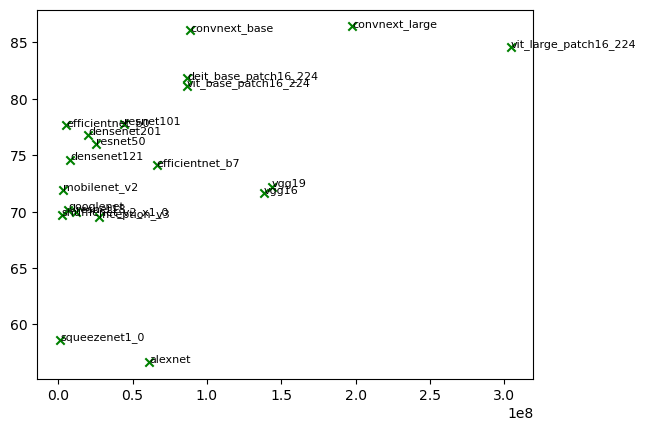

In [48]:
num_of_params = [get_n_params(model_zoo[model_name]) for model_name, metrics in results.items()]
    
plt.scatter(num_of_params, accuracies, label="Models", color='green', marker='x')

for model_name, metrics in results.items():
    plt.text(get_n_params(model_zoo[model_name]), metrics['accuracy'], model_name, fontsize=8)

# plt.title("Pareto Frontier")
# plt.xlabel("Latency (ms)")
# plt.ylabel("Num of Params")

# current = datetime.now().strftime("%Y%m%d_%H%M%S")
# plt.savefig(f"figures/Pareto_Frontier_{current}.png")
    

# model zoo for CIFAR-100

In [18]:
cifar100_results = profile_pt_models(dataset = "cifar100")

loading...  convnext_tiny
load model...
model_name: convnext_tiny w/ dataset: cifar100 (n_classes: 100)


pytorch_model.bin:   0%|          | 0.00/112M [00:00<?, ?B/s]

/tmp/ipykernel_2221222/2728602005.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location='cpu')


loading...  convnext_base
load model...
model_name: convnext_base w/ dataset: cifar100 (n_classes: 100)
loading...  convnext_large
load model...
model_name: convnext_large w/ dataset: cifar100 (n_classes: 100)


pytorch_model.bin:   0%|          | 0.00/786M [00:00<?, ?B/s]

get_eval_loader - cifar100


100%|██████████| 169M/169M [00:02<00:00, 79.7MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Evaluating convnext_tiny...
Processed 504/5000 images...
Processed 1008/5000 images...
Processed 1512/5000 images...
Processed 2016/5000 images...
Processed 2520/5000 images...
Processed 3024/5000 images...
Processed 3528/5000 images...
Processed 4032/5000 images...
Processed 4536/5000 images...
convnext_tiny: Accuracy = 89.44%, Latency = 0.003790 seconds
get_eval_loader - cifar100
Files already downloaded and verified
Evaluating convnext_base...
Processed 504/5000 images...
Processed 1008/5000 images...
Processed 1512/5000 images...
Processed 2016/5000 images...
Processed 2520/5000 images...
Processed 3024/5000 images...
Processed 3528/5000 images...
Processed 4032/5000 images...
Processed 4536/5000 images...
convnext_base: Accuracy = 93.14%, Latency = 0.007230 seconds
get_eval_loader - cifar100
Files already downloaded and verified
Evaluating convnext_large...
Processed 504/5000 images...
Processed 1008/5000 images...
Processed 1512

In [86]:
# tentative;
''' 
cifar100_results = {
    'mobilenetv2_x0_5': {'accuracy': 71.04, 'latency': 0.003705},
    'mobilenetv2_x0_75': {'accuracy': 74.42, 'latency': 0.003691},
    'mobilenetv2_x1_0': {'accuracy': 74.44, 'latency': 0.003612},
    'mobilenetv2_x1_4': {'accuracy': 76.04, 'latency': 0.003700},
    'repvgg_a0': {'accuracy': 76.24, 'latency': 0.004198},
    'repvgg_a1': {'accuracy': 76.44, 'latency': 0.004643},
    'repvgg_a2': {'accuracy': 77.24, 'latency': 0.004182},
    'resnet20': {'accuracy': 68.78, 'latency': 0.001706},
    'resnet32': {'accuracy': 69.42, 'latency': 0.002864},
    'resnet44': {'accuracy': 71.52, 'latency': 0.003663},
    'resnet56': {'accuracy': 72.12, 'latency': 0.004722},
    'shufflenetv2_x0_5': {'accuracy': 67.86, 'latency': 0.004706},
    'shufflenetv2_x1_0': {'accuracy': 73.10, 'latency': 0.004691},
    'shufflenetv2_x1_5': {'accuracy': 74.36, 'latency': 0.004913},
    'shufflenetv2_x2_0': {'accuracy': 75.00, 'latency': 0.004969},
    'vgg11_bn': {'accuracy': 70.44, 'latency': 0.001097},
    'vgg13_bn': {'accuracy': 75.16, 'latency': 0.001294},
    'vgg16_bn': {'accuracy': 74.02, 'latency': 0.001660},
    'vgg19_bn': {'accuracy': 74.68, 'latency': 0.002024},
    'vit_small_patch16_384': {'accuracy': 90.82, 'latency': 0.003616},
    'vit_base_patch16_384': {'accuracy': 90.10, 'latency': 0.003929},
    'vit_large_patch16_384': {'accuracy': 90.04, 'latency': 0.007369}
}
'''
# Convert CSV back to JSON
csv_file = "dataset/cifar100.csv"

# Read the CSV file and convert to JSON
cifar100_results = {}
with open(csv_file, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        model = row["Model"]
        accuracy = float(row["Accuracy"])
        latency = float(row["Latency"])

        cifar100_results[model] = {"accuracy": accuracy, "latency": latency}

In [93]:
cifar100_results

{'mobilenetv2_x0_5': {'accuracy': 71.04, 'latency': 36.91},
 'mobilenetv2_x0_75': {'accuracy': 74.42, 'latency': 37.05},
 'mobilenetv2_x1_0': {'accuracy': 74.44, 'latency': 36.12},
 'mobilenetv2_x1_4': {'accuracy': 76.04, 'latency': 37.0},
 'repvgg_a0': {'accuracy': 76.24, 'latency': 41.82},
 'repvgg_a1': {'accuracy': 76.44, 'latency': 41.98},
 'repvgg_a2': {'accuracy': 77.24, 'latency': 46.43},
 'resnet20': {'accuracy': 68.78, 'latency': 17.06},
 'resnet32': {'accuracy': 69.42, 'latency': 28.64},
 'resnet44': {'accuracy': 71.52, 'latency': 36.63},
 'resnet56': {'accuracy': 72.12, 'latency': 47.22},
 'shufflenetv2_x0_5': {'accuracy': 67.86, 'latency': 46.91},
 'shufflenetv2_x1_0': {'accuracy': 73.1, 'latency': 47.06},
 'shufflenetv2_x1_5': {'accuracy': 74.36, 'latency': 49.13},
 'shufflenetv2_x2_0': {'accuracy': 75.0, 'latency': 49.69},
 'vgg11_bn': {'accuracy': 70.44, 'latency': 10.97},
 'vgg13_bn': {'accuracy': 74.02, 'latency': 12.94},
 'vgg16_bn': {'accuracy': 74.68, 'latency': 16.

In [87]:
latencies = [metrics['latency'] for model_name, metrics in cifar100_results.items()]
accuracies = [metrics['accuracy'] for model_name, metrics in cifar100_results.items()]

mobilenetv2_x0_5, acc: 71.04, mean latency: 36.910 ms
mobilenetv2_x0_75, acc: 74.42, mean latency: 37.050 ms
mobilenetv2_x1_0, acc: 74.44, mean latency: 36.120 ms
mobilenetv2_x1_4, acc: 76.04, mean latency: 37.000 ms
repvgg_a0, acc: 76.24, mean latency: 41.820 ms
repvgg_a1, acc: 76.44, mean latency: 41.980 ms
repvgg_a2, acc: 77.24, mean latency: 46.430 ms
resnet20, acc: 68.78, mean latency: 17.060 ms
resnet32, acc: 69.42, mean latency: 28.640 ms
resnet44, acc: 71.52, mean latency: 36.630 ms
resnet56, acc: 72.12, mean latency: 47.220 ms
shufflenetv2_x0_5, acc: 67.86, mean latency: 46.910 ms
shufflenetv2_x1_0, acc: 73.1, mean latency: 47.060 ms
shufflenetv2_x1_5, acc: 74.36, mean latency: 49.130 ms
shufflenetv2_x2_0, acc: 75.0, mean latency: 49.690 ms
vgg11_bn, acc: 70.44, mean latency: 10.970 ms
vgg13_bn, acc: 74.02, mean latency: 12.940 ms
vgg16_bn, acc: 74.68, mean latency: 16.600 ms
vgg19_bn, acc: 75.16, mean latency: 20.240 ms
vit_small_patch16_384, acc: 90.04, mean latency: 36.160 

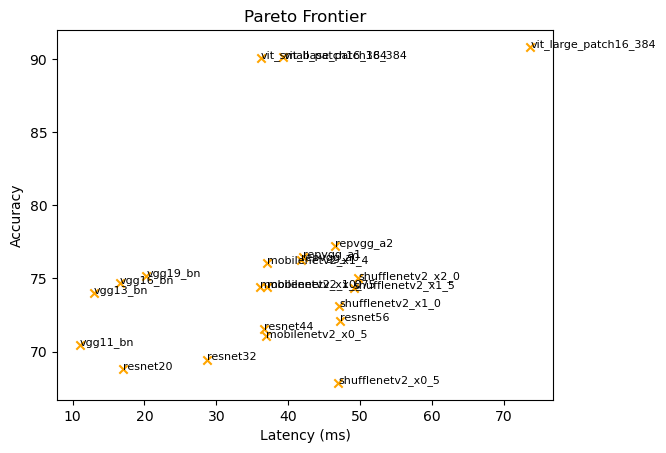

In [88]:
for model_name, metrics in cifar100_results.items():
    print(f"{model_name}, acc: {metrics['accuracy']}, mean latency: {metrics['latency']:.3f} ms")
    
plt.scatter(latencies, accuracies, label="Models", color='orange', marker='x')

for model_name, metrics in cifar100_results.items():
    plt.text(metrics['latency'], metrics['accuracy'], model_name, fontsize=8)

plt.title("Pareto Frontier")
plt.xlabel("Latency (ms)")
plt.ylabel("Accuracy")

current = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f"figures/Pareto_Frontier_{current}.png")